%pip install -r requirements.txt

In [13]:
# !python -m spacy info

In [14]:
# !python -m spacy download en_core_web_sm

In [1]:
import spacy
import numpy as np 
import nltk
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
candidate_data = pd.read_csv('potential-talents.csv')

In [3]:
candidate_data.head()

,id,job_title,location,connection,fit
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [4]:
candidate_data['job_title_char_count'] = candidate_data['job_title'].astype(str).apply(len)
candidate_data['job_title_word_count'] = candidate_data['job_title'].astype(str).apply(lambda x: len(x.split()))
candidate_data['job_title_avg_word_length'] = candidate_data['job_title'].astype(str).apply(
    lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Get English stopwords from spaCy
stopwords = nlp.Defaults.stop_words

def lemmatize_and_filter(text):
    doc = nlp(str(text))
    return [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and token.is_alpha
    ]

# Apply lemmatization and stopword removal to job_title
job_title_tokens = candidate_data['job_title'].fillna('').apply(lemmatize_and_filter)

# Join tokens back to string for vectorizer input
job_title_processed = job_title_tokens.apply(lambda tokens: ' '.join(tokens))

# Unigrams
vectorizer_uni_lem = CountVectorizer(ngram_range=(1, 1))
unigrams_lem = vectorizer_uni_lem.fit_transform(job_title_processed)
unigram_features_lem = vectorizer_uni_lem.get_feature_names_out()

# Bigrams
vectorizer_bi_lem = CountVectorizer(ngram_range=(2, 2))
bigrams_lem = vectorizer_bi_lem.fit_transform(job_title_processed)
bigram_features_lem = vectorizer_bi_lem.get_feature_names_out()

# Trigrams
vectorizer_tri_lem = CountVectorizer(ngram_range=(3, 3))
trigrams_lem = vectorizer_tri_lem.fit_transform(job_title_processed)
trigram_features_lem = vectorizer_tri_lem.get_feature_names_out()

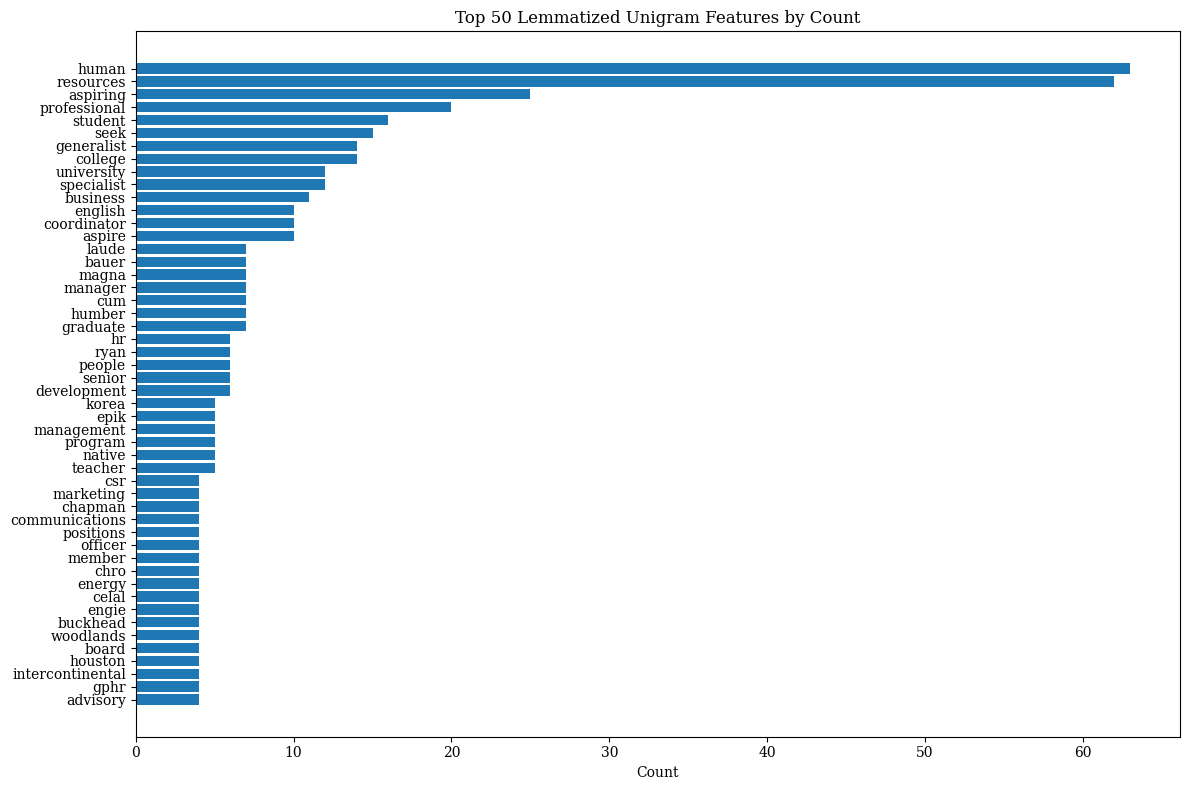

In [ ]:
plt.rcParams['font.family'] = 'serif'
# Get the top 50 features and their counts from unigram_features_lem and unigram_counts_lem
unigram_counts_lem = unigrams_lem.sum(axis=0).A1
top_n = 50
top_indices = np.argsort(unigram_counts_lem)[::-1][:top_n]
top_features = unigram_features_lem[top_indices]
top_counts = unigram_counts_lem[top_indices]

plt.figure(figsize=(12, 8))
plt.barh(top_features[::-1], top_counts[::-1])
plt.xlabel('Count')
plt.title('Top 50 Lemmatized Unigram Features by Count')
plt.tight_layout()
plt.show()

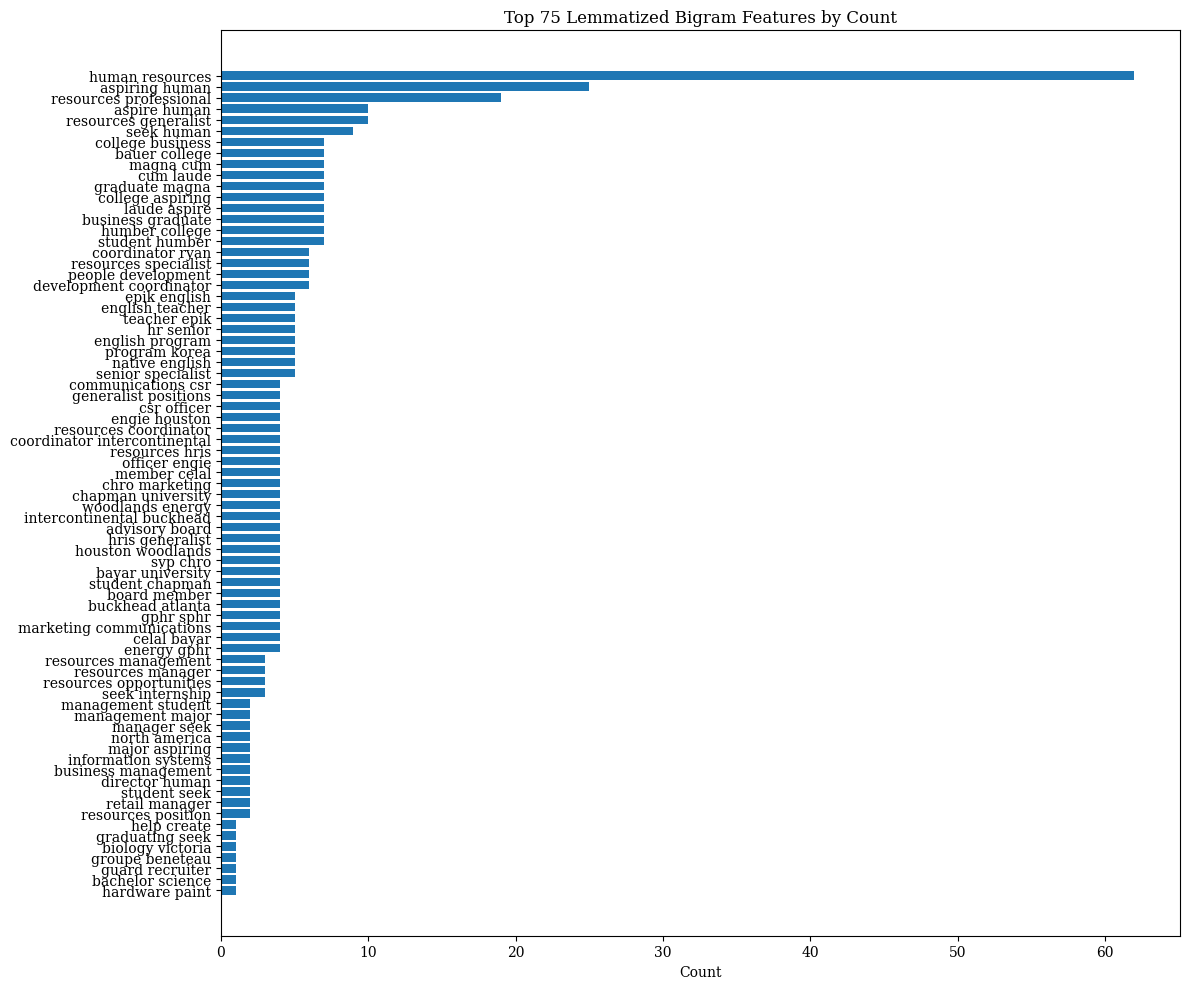

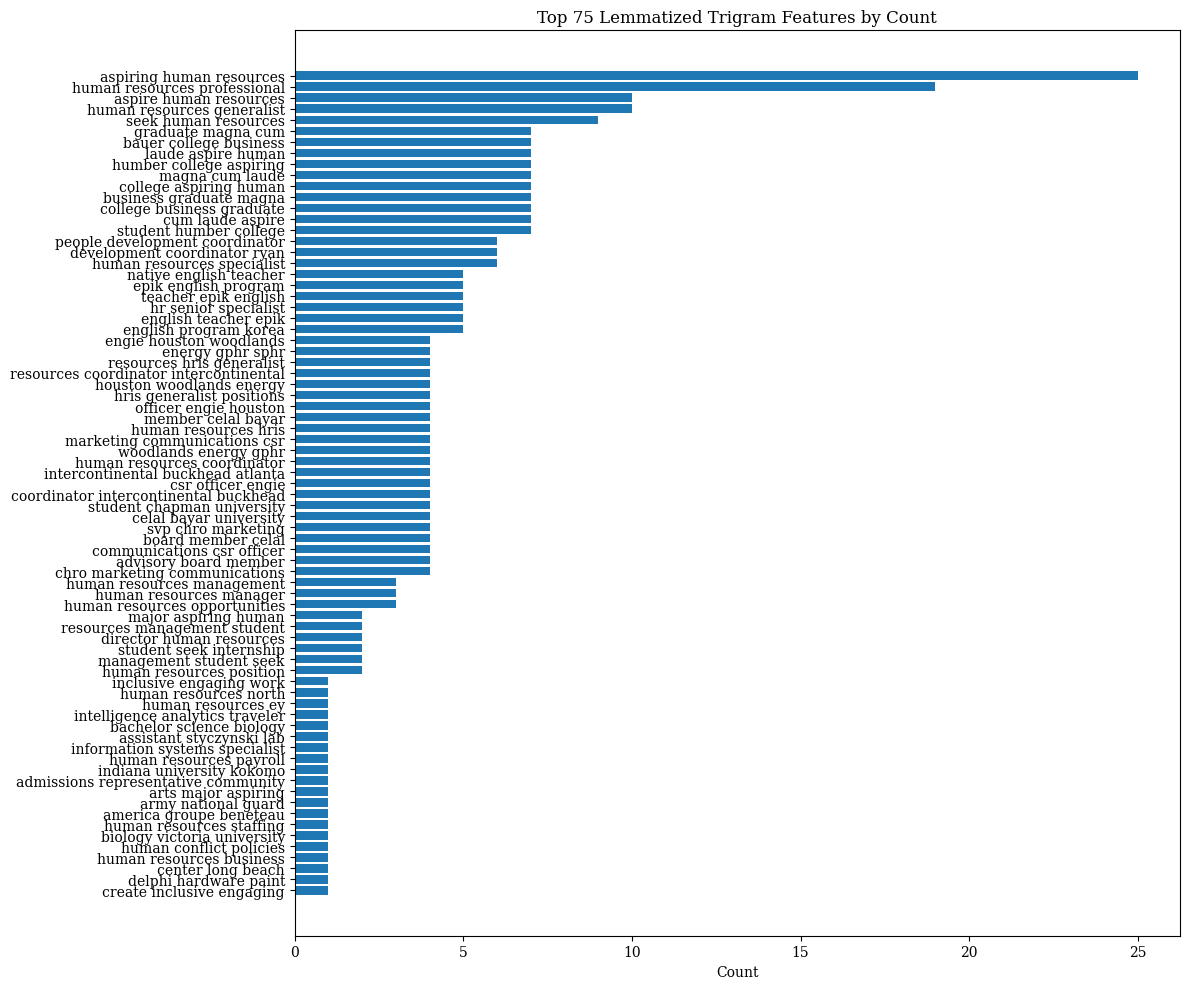

In [16]:
# Calculate bigram counts
bigram_counts_lem = bigrams_lem.sum(axis=0).A1
top_n = 75
top_bi_indices = np.argsort(bigram_counts_lem)[::-1][:top_n]
top_bi_features = bigram_features_lem[top_bi_indices]
top_bi_counts = bigram_counts_lem[top_bi_indices]

plt.figure(figsize=(12, 10))
plt.barh(top_bi_features[::-1], top_bi_counts[::-1])
plt.xlabel('Count')
plt.title('Top 75 Lemmatized Bigram Features by Count')
plt.tight_layout()
plt.show()

# Calculate trigram counts
trigram_counts_lem = trigrams_lem.sum(axis=0).A1
top_tri_indices = np.argsort(trigram_counts_lem)[::-1][:top_n]
top_tri_features = trigram_features_lem[top_tri_indices]
top_tri_counts = trigram_counts_lem[top_tri_indices]

plt.figure(figsize=(12, 10))
plt.barh(top_tri_features[::-1], top_tri_counts[::-1])
plt.xlabel('Count')
plt.title('Top 75 Lemmatized Trigram Features by Count')
plt.tight_layout()
plt.show()

In [17]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Apziva\Project3\nlp_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [19]:
from gensim.models import Word2Vec

# Prepare tokenized job titles for Word2Vec (skip empty lists)
job_title_token_lists = job_title_tokens[job_title_tokens.apply(lambda x: len(x) > 0)].tolist()

# Train Word2Vec model
w2v_model = Word2Vec(sentences=job_title_token_lists, vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Example: Get embedding for a word
embedding_human = w2v_model.wv['human']

# Example: Get average embedding for a job title (row 0)
def get_avg_embedding(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

candidate_data['job_title_w2v'] = job_title_tokens.apply(lambda tokens: get_avg_embedding(tokens, w2v_model))

In [20]:
candidate_data.head()

,id,job_title,location,connection,fit,job_title_char_count,job_title_word_count,job_title_avg_word_length,job_title_w2v
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,104,15,6.000000,"[0.00036833622, 0.00068445667, 0.0022626421, -..."
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,57,9,5.444444,"[0.0042952755, -0.0008027732, 0.0020055478, 0...."
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,37,4,8.500000,"[-0.0016007519, 0.0037685886, -0.00039690756, ..."
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,38,5,6.800000,"[0.00019763701, -0.003483134, -0.001574704, -0..."
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,47,7,5.857143,"[0.0018560245, -0.00045984457, -0.0003801426, ..."


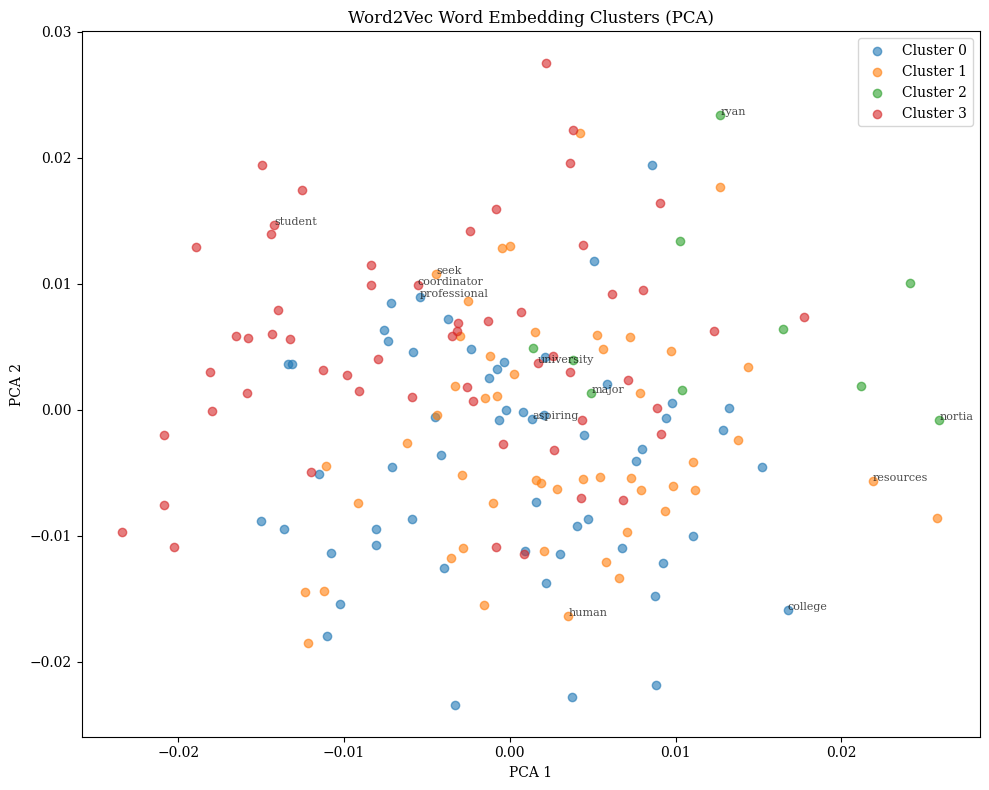

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Get all unique words from the Word2Vec model
words = list(w2v_model.wv.index_to_key)
embeddings = np.array([w2v_model.wv[word] for word in words])

# Compute cosine similarity matrix (optional, for inspection)
# cosine_sim_matrix = cosine_similarity(embeddings)

# Cluster word embeddings
n_clusters = 4 # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings)

# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Plot clusters
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    idx = labels == i
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Cluster {i}', alpha=0.6)
    # Annotate a few words per cluster
    for j in np.where(idx)[0][:3]:
        plt.annotate(words[j], (embeddings_2d[j, 0], embeddings_2d[j, 1]), fontsize=8, alpha=0.7)

plt.title('Word2Vec Word Embedding Clusters (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
%pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Apziva\Project3\nlp_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [25]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate SBERT embeddings for the 'job_title' feature
candidate_data['job_title_sbert'] = list(sbert_model.encode(candidate_data['job_title'].astype(str), show_progress_bar=True))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

d:\Apziva\Project3\nlp_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\samar\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [26]:
candidate_data.head()

,id,job_title,location,connection,fit,job_title_char_count,job_title_word_count,job_title_avg_word_length,job_title_w2v,job_title_sbert
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,104,15,6.000000,"[0.00036833622, 0.00068445667, 0.0022626421, -...","[-0.07176387, 0.0022636321, -0.01785828, 0.031..."
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,57,9,5.444444,"[0.0042952755, -0.0008027732, 0.0020055478, 0....","[-0.012136347, 0.01905449, 0.03814821, 0.01352..."
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,37,4,8.500000,"[-0.0016007519, 0.0037685886, -0.00039690756, ...","[-0.03121112, 0.047989454, -0.014072438, 0.099..."
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,38,5,6.800000,"[0.00019763701, -0.003483134, -0.001574704, -0...","[-0.106952295, -0.020745076, -0.08798131, 0.04..."
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,47,7,5.857143,"[0.0018560245, -0.00045984457, -0.0003801426, ...","[-0.09358542, 0.02436638, -0.008675729, -0.002..."


In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

# Convert SBERT embeddings to numpy array
sbert_embeddings = np.vstack(candidate_data['job_title_sbert'].values)

# Compute cosine similarity matrix (optional, for inspection)
similarity_matrix = cosine_similarity(sbert_embeddings)

# Cluster using Agglomerative Clustering (number of clusters can be adjusted)
n_sbert_clusters = 5
sbert_clusterer = AgglomerativeClustering(n_clusters=n_sbert_clusters, affinity='cosine', linkage='average')
sbert_labels = sbert_clusterer.fit_predict(sbert_embeddings)

# Add cluster labels to the dataframe
candidate_data['job_title_sbert_cluster'] = sbert_labels

d:\Apziva\Project3\nlp_env\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [28]:
candidate_data.head()

,id,job_title,location,connection,fit,job_title_char_count,job_title_word_count,job_title_avg_word_length,job_title_w2v,job_title_sbert,job_title_sbert_cluster
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,104,15,6.000000,"[0.00036833622, 0.00068445667, 0.0022626421, -...","[-0.07176387, 0.0022636321, -0.01785828, 0.031...",0
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,57,9,5.444444,"[0.0042952755, -0.0008027732, 0.0020055478, 0....","[-0.012136347, 0.01905449, 0.03814821, 0.01352...",0
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,37,4,8.500000,"[-0.0016007519, 0.0037685886, -0.00039690756, ...","[-0.03121112, 0.047989454, -0.014072438, 0.099...",0
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,38,5,6.800000,"[0.00019763701, -0.003483134, -0.001574704, -0...","[-0.106952295, -0.020745076, -0.08798131, 0.04...",0
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,47,7,5.857143,"[0.0018560245, -0.00045984457, -0.0003801426, ...","[-0.09358542, 0.02436638, -0.008675729, -0.002...",0


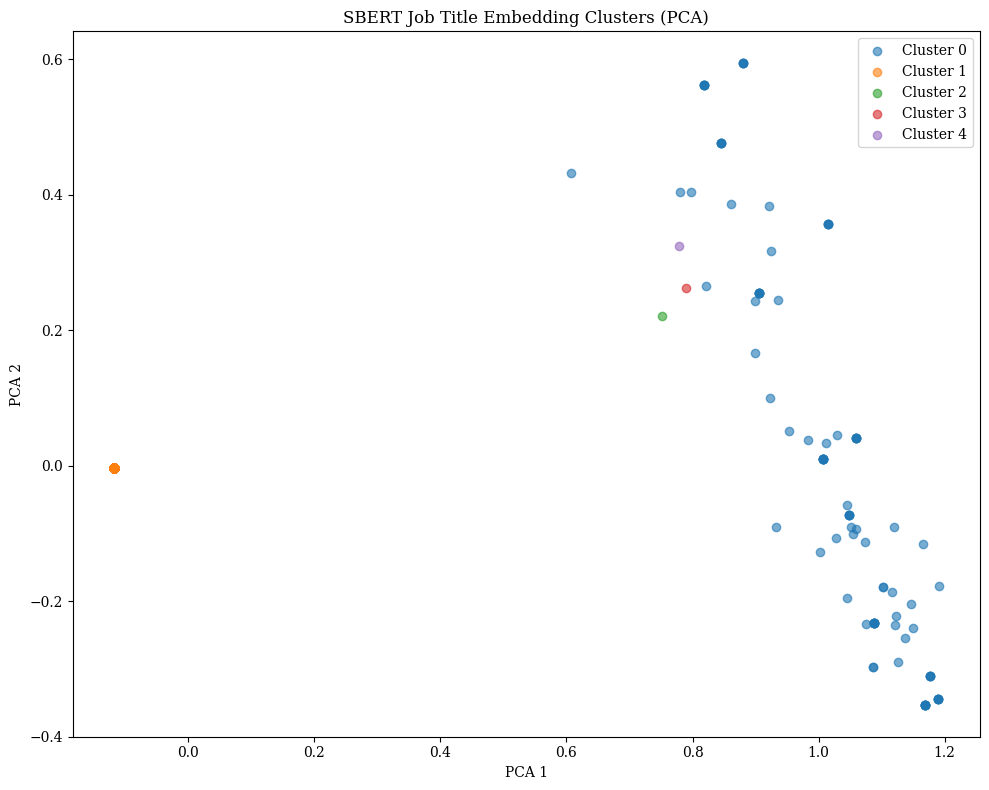

In [31]:
from sklearn.decomposition import PCA

# Visualize SBERT clusters using PCA for dimensionality reduction

# Reduce SBERT embeddings to 2D for visualization
pca_sbert = PCA(n_components=2, random_state=42)
sbert_2d = pca_sbert.fit_transform(sbert_embeddings)

plt.figure(figsize=(10, 8))
for i in range(n_sbert_clusters):
    idx = sbert_labels == i
    plt.scatter(sbert_2d[idx, 0], sbert_2d[idx, 1], label=f'Cluster {i}', alpha=0.6)

plt.title('SBERT Job Title Embedding Clusters (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.legend()
plt.tight_layout()
plt.show()